***Clustering and dimensionality reduction***

The data in wine.csv contains information on 11 chemical properties of 6500 different bottles of vinho verde wine from northern Portugal. In addition, two other variables about each wine are recorded:

whether the wine is red or white
the quality of the wine, as judged on a 1-10 scale by a panel of certified wine snobs.
Run PCA, tSNE, and any clustering algorithm of your choice on the 11 chemical properties (or suitable transformations thereof) and summarize your results. Which dimensionality reduction technique makes the most sense to you for this data? Convince yourself (and me) that your chosen approach is easily capable of distinguishing the reds from the whites, using only the "unsupervised" information contained in the data on chemical properties. Does your unsupervised technique also seem capable of distinguishing the higher from the lower quality wines? Present appropriate numerical and/or visual evidence to support your conclusions.

To clarify: I'm not asking you to run a supervised learning algorithms. Rather, I'm asking you to see whether the differences in the labels (red/white and quality score) emerge naturally from applying an unsupervised technique to the chemical properties. This should be straightforward to assess using plots.

To assess whether the color and quality of wines can be naturally distinguished from applying unsupervised techniques, we used PCA, PCA with K means, T-SNE, and T-SNE with quality. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

wine = pd.read_csv('/Users/brindaasuri/Desktop/MSBA/wine.csv')

wine.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [2]:
wine_subset = wine.drop(columns=['color', 'quality'])

In [3]:
scaler = StandardScaler()
wine_subset_scaled = scaler.fit_transform(wine_subset)

In [4]:
#remove duplicate rows
wine = wine.drop_duplicates()

#all columns except 'color' and 'quality' as they have 0 values
wine_subset = wine.drop(columns=['color', 'quality'])

#scale subset of data
scaler = StandardScaler()
wine_subset_scaled = scaler.fit_transform(wine_subset)

#duplicate rows in the scaled data (considering both forward and backward duplicates)
duplicate_rows = pd.DataFrame(wine_subset_scaled).duplicated() | pd.DataFrame(wine_subset_scaled).duplicated(keep='last')

#get rid of duplicate rows from scaled data and df
wine_subset_scaled = wine_subset_scaled[~duplicate_rows]
wine = wine[~duplicate_rows.values] # Use .values to extract the boolean values without the misaligned index

#fit PCA
pca = PCA()
pca_result = pca.fit_transform(wine_subset_scaled)

***PCA By Color***

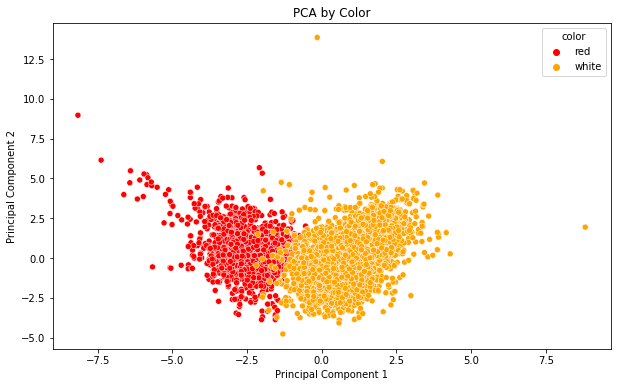

In [5]:
pca_data_color = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'color': wine['color']
})

#color mapping
color_mapping = {'white': 'orange', 'red': 'red'}

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='color', data=pca_data_color, palette=color_mapping)

plt.title('PCA by Color')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

Looking at the plot for PCA by Color, we can see that the plot does separate whites from red quite clearly. This means that PCA does a fairly good job at identifying the different clusters and that the chemical properties chosen for PCA contain a good amount of information to help separate the colors. There is some overlap, which may indicate that there is potential for higher accuracy of separation. 

***K Means PCA By Color***

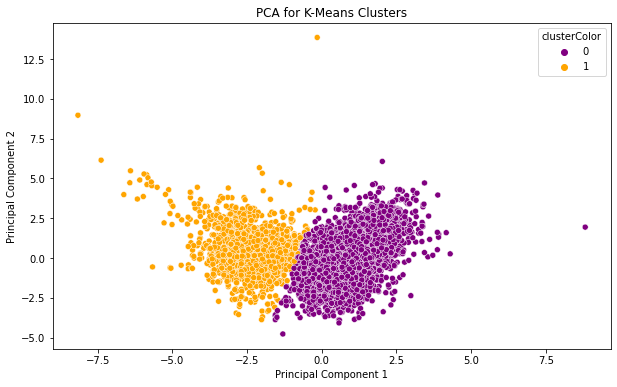

In [6]:
K = 2

kmeans = KMeans(n_clusters=K, n_init=20, random_state=42)
pca_data_color['clusterColor'] = kmeans.fit_predict(pca_data_color[['PC1', 'PC2']])

pca_data_color['clusterColor'] = pca_data_color['clusterColor'].astype('category')

color_mapping = {0: 'purple', 1: 'orange'}

#convert the cluster labels to integers for the color mapping
pca_data_color['clusterColor'] = pca_data_color['clusterColor'].astype(int)

#plot the PCA data with K-means cluster colors
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='clusterColor', data=pca_data_color, palette=color_mapping)

plt.title('PCA for K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

This graph is much better than the PCA plot without K means. We can see that in comparison to the previous plot, this does a much more efficient job of clustering. We can determine again, that the chemical properties contain a high level of information to differentiate the red and white wines well.

In [7]:
from sklearn.metrics import accuracy_score

color_mapping_inverse = {'white': 0, 'red': 1}
pca_data_color['color_numeric'] = pca_data_color['color'].map(color_mapping_inverse).fillna(-1)

pca_confusion_matrix = pd.crosstab(pca_data_color['color'], pca_data_color['clusterColor'])

#print the confusion matrix
print("Confusion Matrix:")
print(pca_confusion_matrix)

#calculate the accuracy
accuracy = accuracy_score(pca_data_color['color_numeric'], pca_data_color['clusterColor'])

#print the accuracy
print(f"Accuracy of PCA with K Means clustering: {accuracy * 100}%")

Confusion Matrix:
clusterColor     0     1
color                   
red             28  1329
white         3889    70
Accuracy of PCA with K Means clustering: 98.15650865312266%


This really high accuracy level tells us how great PCA with k-means is with differentiating between colors.

***PCA for Quality***

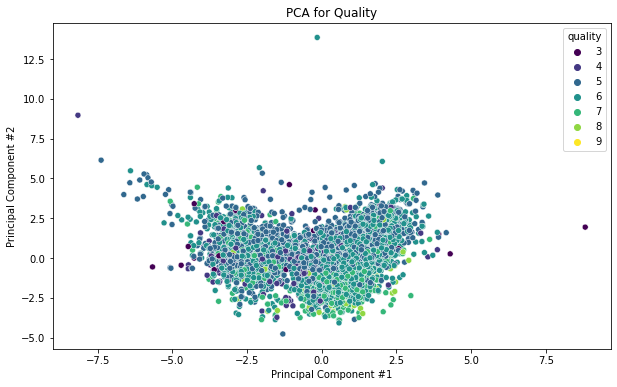

In [8]:
pca_data_quality = pd.DataFrame({
    'PC1': pca_result[:, 0],  #pc #1
    'PC2': pca_result[:, 1],  #pc #2
    'quality': wine['quality']  #quality
})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='quality', data=pca_data_quality, palette='viridis')

plt.title('PCA for Quality')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

PCA for quality does not do a great job at clustering the different qualities. We can see above that the different qualities are all jumbled together and hard to discern apart. 

***PCA K Means for Quality***

In [9]:
K = 10

#K-means clustering on the two pcs
kmeans_pca_result_quality = KMeans(n_clusters=K, n_init=20, random_state=42)
pca_data_quality['clusterQuality'] = kmeans_pca_result_quality.fit_predict(pca_data_quality[['PC1', 'PC2']])

#convert to categorical
pca_data_quality['clusterQuality'] = pca_data_quality['clusterQuality'].astype('category')

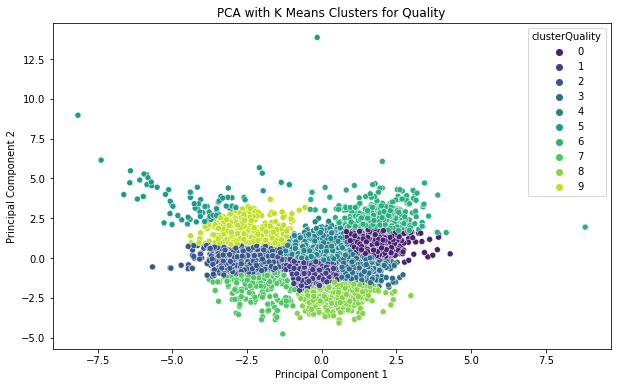

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='clusterQuality', data=pca_data_quality, palette='viridis')

plt.title('PCA with K Means Clusters for Quality')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

In the plot above, using k-means, we can see that there is a clearer separation of clusters. This means that the k-mens algorithm is doing a better job at identifying the different groups of qualities. We can also see that the first principal component captures the most variance in the data given by the wide spread of the clusters and points. 

In [11]:
cluster_quality_means = pca_data_quality.groupby('clusterQuality')['quality'].mean().reset_index()

print(cluster_quality_means)

  clusterQuality   quality
0              0  5.613982
1              1  5.799180
2              2  5.607306
3              3  6.064683
4              4  5.441652
5              5  5.500000
6              6  5.525773
7              7  5.794444
8              8  6.435964
9              9  5.531915


***T-SNE By Color***

In [ ]:
#t-SNE
import pandas as pd
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(wine_subset_scaled)

#for the t-SNE results and add the color information
tsne_data = pd.DataFrame({
    'TSNE_1': tsne_result[:, 0],
    'TSNE_2': tsne_result[:, 1],
    'color': wine['color']
})

tsne_data.head()

In [ ]:
color_mapping = {'white': 'orange', 'red': 'red'}

#plot the t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='color', data=tsne_data, palette=color_mapping)

#title and labels
plt.title('t-SNE by Color')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

#apply minimal theme
sns.set_theme(style='whitegrid')

plt.show()

This t-SNE plot does a much better job at clustering the different segments. We can see that this plot is potentially better at splitting than PCA. However, we can still see that a few points are not separated accuratly. 

***T-SNE K Means By Color***

In [38]:
K = 2

#perform K-means clustering on the t-SNE data
kmeans_tsne_result_color = KMeans(n_clusters=K, n_init=20, random_state=42)
tsne_data['clusterColor'] = kmeans_tsne_result_color.fit_predict(tsne_data[['TSNE_1', 'TSNE_2']])

#convertto a categorical type
tsne_data['clusterColor'] = tsne_data['clusterColor'].astype('category')

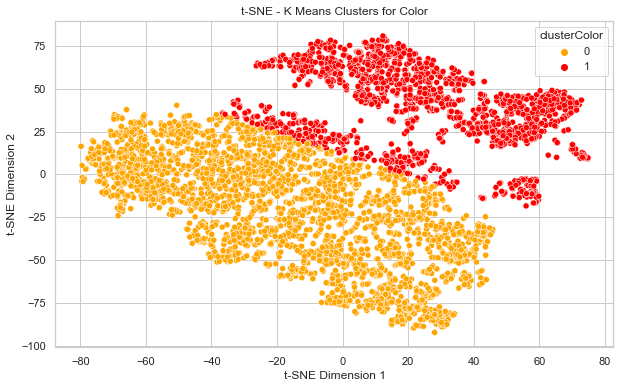

In [40]:
color_mapping = {0: 'orange', 1: 'red'}

#plot the t-SNE results with cluster colors
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusterColor', data=tsne_data, palette=color_mapping)

plt.title('t-SNE - K Means Clusters for Color')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')


plt.show()

This T-SNE plot seems to show a more accurate separation than the t-sne without K-means. Unlike the previous plot, the colored clusters here are clearly separated. T-SNE seems to accuratley capture relevature properties here.

In [15]:
tSNE_color_confusion_matrix = pd.crosstab(tsne_data['color'], tsne_data['clusterColor'])

#confusion matrix
print(tSNE_color_confusion_matrix)

clusterColor     0     1
color                   
red             13  1344
white         3441   518


***T-SNE for Quality***

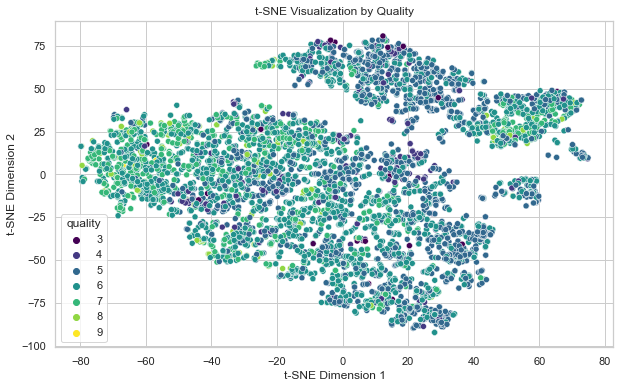

In [20]:
#t-SNE for wine quality
tsne_quality = TSNE(n_components=2, random_state=42)
tsne_result_quality = tsne_quality.fit_transform(wine_subset_scaled)

#create a DataFrame
tsne_data_quality = pd.DataFrame({
    'TSNE_1': tsne_result_quality[:, 0],
    'TSNE_2': tsne_result_quality[:, 1],
    'quality': wine['quality']
})

#display the first few rows of the result
tsne_data_quality.head()

#plot the t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='quality', data=tsne_data_quality, palette='viridis')

#add title and labels
plt.title('t-SNE Visualization by Quality')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')


plt.show()

Looking at the grouping above, there seems to be significant overlap between various quality scores, indicating that both red and white wines have various quality scores and that chemical properties alone can not directly determine quality score.

***T-SNE K Means for Quality***

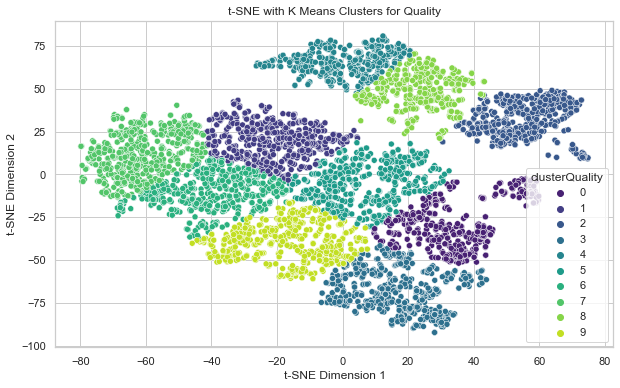

  clusterQuality   quality
0              0  5.433781
1              1  6.032432
2              2  5.988281
3              3  5.564388
4              4  5.504505
5              5  5.626998
6              6  5.780261
7              7  6.558020
8              8  5.274600
9              9  6.015038


In [41]:
#K-means on t-SNE data
K = 10  
kmeans_tsne_result_quality = KMeans(n_clusters=K, n_init=20, random_state=42)
tsne_data_quality['clusterQuality'] = kmeans_tsne_result_quality.fit_predict(tsne_data_quality[['TSNE_1', 'TSNE_2']])

#convert the cluster labels to a categorical type 
tsne_data_quality['clusterQuality'] = tsne_data_quality['clusterQuality'].astype('category')

#plot the t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusterQuality', data=tsne_data_quality, palette='viridis')

plt.title('t-SNE with K Means Clusters for Quality')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.show()

cluster_quality_means_tsne = tsne_data_quality.groupby('clusterQuality')['quality'].mean().reset_index()
print(cluster_quality_means_tsne)

This graph much more effectively identifies the different qualities via the various quality ranges. 

Overall, both PCA and t-SNE are able to distinguish between both red and white wine, but looking at the graphs and plot separation successes, we can see that t-SNE seems to do an overall much better job. With both methods for assessing color separation, K-means seems to lead to clearer outcomes. Therefore for assessing color separation, t-SNE with k-means seems to be the optimal model. When distinguishing quality, both PCA and t-SNE alone do not seem to perform well. There is several overlap between high and low quality wines within both plots. However, when adding the k-means algorithm, we can see that the results tend to improve signifcantly with t-SNE being the better model. 